<a href="https://colab.research.google.com/github/dgromann/SemComp_WS2018/blob/master/Tutorial9/Tutorial9_model_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Lesson 0.0.0: Store this notebook! 

Go to "File" and make sure you store this file as a local copy to either GitHub or your Google Drive. If you do not have a Google account and also do not want to create one, please check Option C below. 

Option A) Google Drive WITH collaboration

If you want to work in a collaborative manner where each of you in the group can see each other's contributions, one of you needs to store the notebook in Google Drive and share it with the others. You share it by clicking on the SHARE button on the top right of this page and share the link with the "everyone who receives this link can edit" option with the other team members per e-mail, skype, or any other way you prefer.

If you work with others, keep in mind to always copy the code before you edit it and always indicate your name as a comment (e.g. #Dagmar ) in the cell that it is clear who wrote which part. I also recommend creating a new code cell for your contributions.

Option B) Github without collaboration

Collaborative functions are not available when storing the notebook in GitHub; you will see your own work but not that of others.


Option C) Download this notebook as ipynb (Jupyter notebook) or py (Python file)

To run either of these on your local machine requires the installation of the required programs, which for the first tutorial are Python and NLTK. This will become more as we continue on to machine learning (requiring sklearn) and deep learning (requiring tensorflow and/or pytorch). In Google Codelab all of these are provided and do not need to be installed locally.

This tutorial has been adapted from [this pytorch Seq2Seq tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).

# Lesson 1.0: Encoder-Decoder Sequence to Sequence Learning with Attention

Before we get into ontology learning we need to understand the architecture. So today we will build an encoder decoder sequence to sequence learning model with attention that we will use next week to build ontologies automatically from text. The problem will be restricted to certain type of sequences to translate to a specific case of ontological statement, since the overall problem of ontology learning is an open problem. 

## Exercises in this lesson

**Before** you get started with coding, answer the following questions: 
1.   What is the problem we want to solve here? What is our prediction?
2.   What are the preprocessing steps? (here you can run the cells under point 1.1.) 
3.   Which type of optimizer does this code use and with which batch configuration?
4.   Which kind of other optimization is done below? 

Answers: 
1. NMT where we translate from English to German 
2. We insert a blank space to the punctuation so that it is not attached to words (e.g. dog! vs. dog !) and we remove everything but .!? and actual letters including some special German characters, such as ä
3. SGD with full batch - update after each input and output sequence
4. Attention and dropout 

**These are the programming steps of today: **
1.   Write your own Encoder
2.   Complete the Decoder 
3.   Start a training run (see # Exercise comments below)
4.   Evaluate the model using the existing functions 

**After** you have finished training and evlauating, answer the following questions:
1.   Where do we have to place the attention layer? What does it take as input? What is the output?
2.   What is the difference between loss and perplexity (ppl)?
3.   How could we improve the optimization in training?
4.   How could we improve the evaluation? 


Answers: 
1. Right at the beginning of the decoder. It takes the embeddings (dropped out) of the input sequence (English) as input.
2. Loss is the loss function output (negative log likelihood here) which tells us far we are from the real answer for each sequence (average over batch) whereas perplexity uses the accumulated loss to calculate how confident the model is in its predictions
3. We could turn the approach into mini-batch and use beam search. A different optimizer with a decaying learning rate could obtain better results. We could consider doing batch normalization.
4. We should do a complete evaluation using BLEU or a similar metric. 

In [2]:
!pip3 install torch

import unicodedata
import string
import re
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1.1 Datasets

In Neural Machine Translation (NMT) research it is common to use the datasets provided by the Shared Task on Machine Translation at the Workshop on Statistical Machine Translation (WMT), especially [WMT'14](http://www.statmt.org/wmt14/translation-task.html) with a more polished version provided on this [Stanford project page](https://nlp.stanford.edu/projects/nmt/). However, those datasets have 4.5 M parallele sentences, which takes too long for us to compute today. 

Instead, we are going to use a smaller corpus provided at the [Tatoeba project](https://www.manythings.org/anki/). The version below is targeted at German to English but feel free to replace the languages by any pair you are interested in. Translation pairs are tab delimitied: 




```
I'm up.	  Ich bin wach.
Go ahead!	Nur zu!
I get by.	Ich komme klar.
```



In [3]:
# Loading the dataset
!wget https://raw.githubusercontent.com/dgromann/SemComp_WS2018/master/Tutorial9/en_de.txt

--2019-02-03 13:54:49--  https://raw.githubusercontent.com/dgromann/SemComp_WS2018/master/Tutorial9/en_de.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12816559 (12M) [text/plain]
Saving to: ‘en_de.txt’

en_de.txt           100%[===================>]  12.22M  --.-KB/s    in 0.1s    

2019-02-03 13:54:49 (98.7 MB/s) - ‘en_de.txt’ saved [12816559/12816559]



### Preparing the data

As usual with natural language and neural networks, we need to find out the exact vocabulary of our dataset in both languages. This vocabulary is then matched with a quantifiable index. The index in turn is used to create our one-hot encodings. In contrast, to the toy example on character-level text generation last time, we will do a proper preparing of our data. 

This means that by convention we mark our sequences with a "Start of Sentence" (**SOS**) token to indicate the start and "End of Sentence" (**EOS**), which clearly demarcates the end of the input and has to be the end of the prediction when we finished training. 

In [0]:
SOS_token = 0 
EOS_token = 1

MAX_LENGTH = 10

class WordIndexer: 
  def __init__(self):
    self.word2index = {}
    self.word2count = {}
    self.index2word = {SOS_token:"<SOS>", EOS_token:"<EOS>"} 
    
  def addSequence(self, sequence):
    for word in sequence.split():
      self.addWord(word)
  
  def addWord(self, word): 
    if word not in self.word2index:
      self.word2index[word] = len(self.index2word)
      self.word2count[word] = 1
      self.index2word[len(self.index2word)] = word 
    else: 
      self.word2count[word] += 1 

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [5]:
# We need to read the text file and align the translation pairs
# that are tab delimited in the original data set 

# Lowercase, trim, and remove non-letter characters
def normalize(sequence):
    sequence = sequence.lower().strip()
    sequence = re.sub(r"([.!?])", r" \1", sequence)
    sequence = re.sub(r"[^a-zA-Z.!?äüöß]+", r" ", sequence)
    return sequence

#We read the data, split them into lines, and then separate them into pairs
def readData(filename):
    lines = open(filename, encoding='utf8').read().strip().split('\n')
    pairs = [[normalize(s) for s in l.split('\t')] for l in lines]      
    return pairs
  
def prepareData(filename): 
  pairs = readData(filename)
  print("Length of sentence pairs: ", len(pairs))
  pairs = filterPairs(pairs)
  print("Length of filtered pairs trimmed is %s with Max_legnth %s " % (len(pairs), MAX_LENGTH))
  input_lang = WordIndexer()
  output_lang = WordIndexer()
 
  for pair in pairs:
    input_lang.addSequence(pair[0])
    output_lang.addSequence(pair[1])
    
  print("Number of words in input language: ", len(input_lang.index2word))
  print("Number of words in output language: ", len(output_lang.index2word))
  
  return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData("en_de.txt")
print(random.choice(pairs))

Length of sentence pairs:  176692
Length of filtered pairs trimmed is 132991 with Max_legnth 10 
Number of words in input language:  12434
Number of words in output language:  24789
['he put down his thoughts in his notebook .', 'er schrieb seine gedanken in sein notizbuch nieder .']


## 1.2 Building the model

The model today is an encoder-decoder sequence to sequence model with attention. So basically it is two models (encoder and decoder) combined into one bigger architecture.

### Encoder

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
 
        # Exercise: Initialize the Embedding layer and a Gated Recurrent Unit layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
  
    def forward(self, input, hidden):
        # Exercise: Complete the forward function (embedding requires view(1, 1, -1)) 
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoder with Attention

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Exercise: Write an Embedding layer 
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # Attention and dropout layer are already provided for you 
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        
        
        # Exercise: Write a hidden layer as GRU and a Linear layer to the output
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)  
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)  # Unsqueeze teturns a new tensor with a dimension of size one inserted at the specified position.

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Training

In [0]:
def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ') if len(word) > 0]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)
  
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
training_size = math.ceil(len(pairs)*0.8)
val_size = int((len(pairs) - training_size) / 2)
    
training_data, validation_data, test_data = random_split(pairs, [training_size, val_size, val_size])
    
def training(encoder, decoder, n_iters=10000, print_every=100, plot_every=1000, learning_rate=0.01):
    
    start = time.time()
    losses = [] # Stores the actual losses
    plot_losses = [] # Stores the average losses
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
   
    training_pairs = [tensorsFromPair(random.choice(training_data)) for i in range(n_iters)]                                      
    
    for iter in range(1, n_iters + 1):
        #as always, initialize hidden state and reset gradients 
        encoder_hidden = encoder.initHidden()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        # get training pair 
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
    
        loss = 0
         
        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
        
        # We run through the input sequence
        for pos in range(input_length):
          encoder_output, encoder_hidden = encoder(input_tensor[pos], encoder_hidden)
          encoder_outputs[pos] = encoder_output[0, 0]
          
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        
        # We keep on predicting until we hit EOS - in training we know how long the output sequence should be
        for pos in range(target_length):
          decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
          topv, topi = decoder_output.topk(1) # Returns the k largest elements of the given input tensor along a given dimension.
          decoder_input = topi.squeeze().detach() # Squeeze returns a tensor with all the dimensions of input of size 1 removed.

          loss += criterion(decoder_output, target_tensor[pos])
          if decoder_input.item() == EOS_token:
            break
        
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
    
        loss = loss.item() / target_length 
        
        losses.append(loss)
        print_loss_total += loss
        plot_loss_total += loss
       

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) loss: %s ppl: %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, np.exp(np.mean(losses))))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

3m 18s (- 62m 52s) (5000 5%) loss: 4.9594050609268425 ppl: 142.5090
6m 33s (- 59m 3s) (10000 10%) loss: 4.4776039061869595 ppl: 112.0006
9m 49s (- 55m 37s) (15000 15%) loss: 4.138372821153699 ppl: 92.3077
13m 5s (- 52m 21s) (20000 20%) loss: 3.919619229145044 ppl: 79.3406
16m 22s (- 49m 7s) (25000 25%) loss: 3.749235780639265 ppl: 70.0247
19m 39s (- 45m 51s) (30000 30%) loss: 3.6334708031070053 ppl: 63.1988
22m 57s (- 42m 38s) (35000 35%) loss: 3.542159901810521 ppl: 57.9732
26m 15s (- 39m 23s) (40000 40%) loss: 3.448084967584976 ppl: 53.7044
29m 33s (- 36m 7s) (45000 45%) loss: 3.3347461333999124 ppl: 49.9694
32m 53s (- 32m 53s) (50000 50%) loss: 3.2405164576995236 ppl: 46.7270
36m 11s (- 29m 36s) (55000 55%) loss: 3.2128319388869113 ppl: 44.1200
39m 28s (- 26m 19s) (60000 60%) loss: 3.1513647457050906 ppl: 41.8441
42m 45s (- 23m 1s) (65000 65%) loss: 3.090154997171533 ppl: 39.8223
46m 3s (- 19m 44s) (70000 70%) loss: 3.0578570258578783 ppl: 38.0794
49m 21s (- 16m 27s) (75000 75%) los

<Figure size 576x396 with 0 Axes>

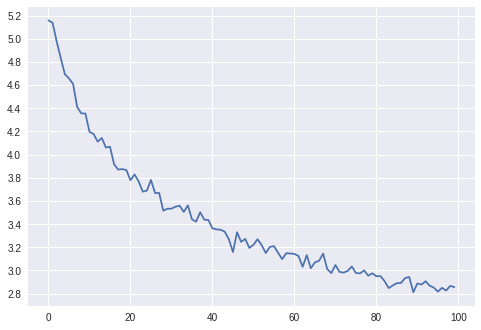

In [12]:
hidden_size = 256
# Exercise: initialize the encoder and attn_decoder and do a training run 
# for all of these the functions are provided - you need to set the right parameters
# Run the utility cell below before you run the training function
encoder = EncoderRNN(len(input_lang.index2word), hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, len(output_lang.index2word), dropout_p=0.1).to(device)

training(encoder, attn_decoder, n_iters=100000, print_every=5000, learning_rate=0.01)

### Utility functions



In [0]:
# Plotting the results
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
# Calculating the time since start    
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### Evaluating the trained model

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

def evaluateRandomly(encoder, decoder, dataset, n=10):
    for i in range(n):
        pair = random.choice(dataset)
        print("Input: ", pair[0])
        print("Target: ", pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print("Prediction: ", output_sentence, "\n")


['hast', 'du', 'mit', 'fertig', '?', '<EOS>']


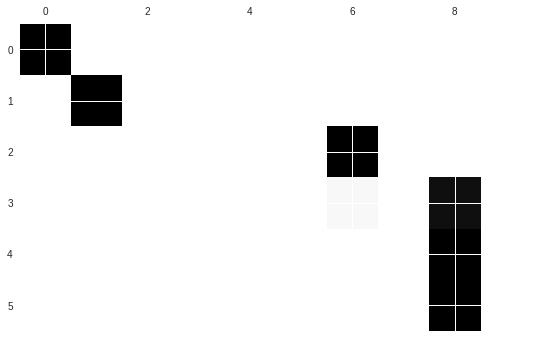

In [14]:
output_words, attentions = evaluate(encoder, attn_decoder, random.choice(pairs)[0])
print(output_words)
plt.matshow(attentions.numpy())

In [15]:
evaluateRandomly(encoder, attn_decoder, test_data, n=10)

Input:  i don t like those people .
Target:  ich mag diese leute nicht .
Prediction:  ich mag diese leute nicht . <EOS> 

Input:  tom lacks discipline .
Target:  es fehlt tom an disziplin .
Prediction:  tom fehlt das an . . <EOS> 

Input:  she watches television from four to six .
Target:  sie sieht von vier bis sechs fern .
Prediction:  sie hat sich zu den . . . <EOS> 

Input:  tom is no longer living in boston .
Target:  tom lebt nicht mehr in boston .
Prediction:  tom ist nicht nicht nicht boston . . <EOS> 

Input:  how many foreign languages do you know ?
Target:  wie viele fremdsprachen könnt ihr ?
Prediction:  wie viele kennst kennst du ? <EOS> 

Input:  tom passed out from the heat .
Target:  tom hat wegen der hitze das bewusstsein verloren .
Prediction:  tom hat aus von der . . <EOS> 

Input:  i am your father .
Target:  ich bin dein vater .
Prediction:  ich bin vater vater . . <EOS> 

Input:  you have to cope with those difficult problems .
Target:  du musst diese schwierigen 